## Periodic boundary condition using Isogeometric Analysis

#### We consider the simplest minimal model of Poisson equation

 Let $\Omega$ be an open set with sufficiently smooth boundary, denoted by , where $d=2$ is the number of spatial dimensions. Then, the problem stated in strong form as :

Find $\phi$, such that
$$ \begin{align*}
    \left\lbrace\begin{array}{lll}
         -\nabla \cdot \nabla \phi~~~~~~~~~~~~~=~ f&\text{ in } \Omega ,~~~~~~~~~~~(1)\\
         \phi ~~~~~~~~~~~~~~~~~~~~~~~~~=~ g&\text{ on } \partial\Omega\cap\mathbf{\tau} ,~~~~~~~~~~~(2)\\
         \text{periodic boundary condition} &\text{ on } \text{comp}(\partial\Omega) ,~~~~~~~~~~~(3)\\
    \end{array}\right.
\end{align*}$$ 
Where in our application we take $\Omega=[0,1]\times[0.,1]$ and $\tau=\partial\Omega\cap\{x=0,1\}$

$$\mathbf{ ~Lower ~ ~and ~ upper  ~boundaries  ~are ~ periodical ~ boundaries ~ for ~ the  ~unknown.}$$

### Formulation variationel

$$ \begin{align*}
    \left\lbrace\begin{array}{lll}
         \int_\Omega \nabla v \cdot\nabla\phi dx+ \color{red}0\int_{\partial\Omega-\tau} v \cdot\partial_n\phi d\sigma~~~~~~~~~~~~~~~~~ =~ \int_\Omega vfdx  &\text{ for all } v \in H^1_g(\Omega),~~~~~~~~~~(15)\\
    \end{array}\right.
\end{align*}$$

$\color{red}0$ : means that we have periodic boundary conditions, then it will be eliminated.

l2-error =  0.4698268616525819
approximate solution


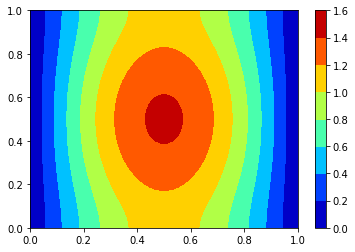

Exact solution


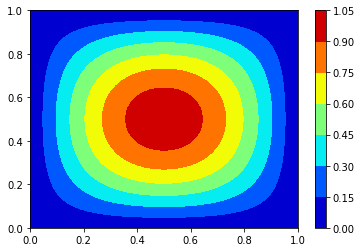

In [20]:
# ## Abstract Model using SymPDE
from sympde.topology.derivatives import dx1, dx2
from sympy                       import Tuple

from sympy                       import pi, cos, sin, exp, log, symbols, sqrt
from sympy.utilities.lambdify    import implemented_function
import pytest

from sympde.calculus             import grad, dot
from sympde.calculus             import laplace
from sympde.topology             import ScalarFunctionSpace
from sympde.topology             import element_of
from sympde.topology             import NormalVector
from sympde.topology             import Square
from sympde.topology             import Union
from sympde.expr                 import BilinearForm, LinearForm, integral
from sympde.expr                 import Norm
from sympde.expr                 import find, EssentialBC
from sympde.expr.expr            import linearize
from sympde.core                 import Constant

from psydac.fem.basic            import FemField
from psydac.api.discretization   import discretize
from psydac.api.settings         import PSYDAC_BACKEND_GPYCCEL

# needed imports
from numpy                       import zeros, ones, linspace, zeros_like, meshgrid
from matplotlib.pyplot           import plot, contourf, show, colorbar
from matplotlib                  import pyplot as plt

import numpy                     as np

from simplines                   import plot_field_2d

from scipy.sparse.linalg         import gmres

# ... 
def get_boundaries(*args):

    if not args:
        return ()
    else:
        assert all(1 <= a <= 4 for a in args)
        assert len(set(args)) == len(args)

    boundaries = {1: {'axis': 0, 'ext': -1},
                  2: {'axis': 0, 'ext':  1},
                  3: {'axis': 1, 'ext': -1},
                  4: {'axis': 1, 'ext':  1}}

    return tuple(boundaries[i] for i in args)

# ... abstract model
domain            = Square(bounds1=(0.,1.), bounds2=(0.,1.))
x,y               = domain.coordinates

#... normal component 
nn                = NormalVector('nn')

#... 
V                 = ScalarFunctionSpace('V', domain)

# ... scalar functions 
u,v               = [element_of(V, name=i) for i in ['u', 'v']]

#  ..... Neumann and Dirichlet boundary conditions
dir_boundary_1    = get_boundaries(1)    
dir_boundary_2    = get_boundaries(2)
# ...
B_dirichlet_1     = Union(*[domain.get_boundary(**kw) for kw in dir_boundary_1])    
B_dirichlet_2     = Union(*[domain.get_boundary(**kw) for kw in dir_boundary_2])
# --- 
Neumann_boundary  = get_boundaries(1, 2)
Neumann_boundary  = Union(*[domain.get_boundary(**kw) for kw in Neumann_boundary])

#...............................................................Data
degree   = [3,3]         # spline degree
ncells   = [64,64]       # number of elements
periodic = [False, True] # periodic boundary condition for y = 0.25 and 0.35 
#... several tests
solution = sin(pi*x)*sin(pi*y)
f        = 2.*pi**2 * sin(pi*x)*sin(pi*y)

#----------------------------------Poisson equation
# Bilinear form or Poisson equation
a_p      = BilinearForm((u, v), integral(domain, dot(grad(u), grad(v)) ) )
#                       -integral(Neumann_boundary, dot(grad(u), nn) * v) ) periodic boundary conditions

# linear form for Poisson equation
l_p      = LinearForm(v, integral(domain, f * v))

# ... Dirichlet boundary condition for Poisson equation
bc_p              = []
if B_dirichlet_1: 
            bc_p += [EssentialBC(u,        solution, B_dirichlet_1)]
if B_dirichlet_2:
            bc_p += [EssentialBC(u,        solution, B_dirichlet_2)]


#+++++++++++++++++++++++++++++++
equation = find(u, forall=v, lhs=a_p(u, v), rhs=l_p(v), bc= bc_p)

##            -------------- Discretization using Psydac --------------            ##

# Create computational domain from topological domain
from mpi4py import MPI
domain_h = discretize(domain, ncells=ncells, comm=MPI.COMM_WORLD)

# Discrete spaces
Vh       = discretize(V, domain_h, degree=degree, periodic = periodic)
#print(Vh.knots)
nbasis = [W.nbasis for W in Vh.spaces]

# Discretize equation using Dirichlet bc
equation_h = discretize(equation, domain_h, [Vh, Vh])

# Solve linear system of Poisson
u_ph     = equation_h.solve()

# Define (abstract) norms
error      = u - solution
l2norm_up  = Norm(error, domain, kind='l2')

# Discretize norms
l2norm_uph = discretize(l2norm_up, domain_h, Vh)

# ... Norm of electric potential
l2normh    = l2norm_uph.assemble(u = u_ph)
print( 'l2-error = ', l2normh)
#....-----------------------------------
nbpts      = 50
I          = linspace(0.,  1.,nbpts)
J          = linspace(0.,  1.,nbpts)
X, Y       = meshgrid(I, J)
sZ         = np.zeros((len(I),len(J)),float)
for i in range(nbpts):
    for j in range(nbpts):
        sZ[i,j]= u_ph(I[i],J[j])

print('approximate solution')

contourf(X, Y, sZ.T, cmap='jet')
colorbar();show()
for i in range(nbpts):
    for j in range(nbpts):
        sZ[i,j]= solution.subs({x:I[i],y:J[j]})
print('Exact solution')
contourf(X, Y, sZ.T, cmap='jet')
colorbar(); show()